# Test 11 {#sec-test_11}
@fig-test_11 is from @Johnson1978 (page 444, problem 16.15). The circuit was drawn in LTSpice and the circuit nodes are labeled. Find the network function, H(s)=V2(s)/V3(s). I made some changes to the values, phases of the windings and coupling constants.

![Test #11 circuit](test_11.png){#fig-test_11}

29 Nov 2023:  
Problem - When the D matrix is built, independent voltage sources are processed in the data frame order when building the D matrix. If the voltage source followed element L, H, F, K types in the netlist, a row was inserted that put the voltage source in a different row in relation to it's position in the Ev matrix. This would cause the node attached to the terminal of the voltage source to be zero volts. 
Solution - added code to move voltage source types to the beginning of the net list data frame before any calculations are performed.  

Need to verify during testing that independednt current sources, type I, do not also need this fix.


The netlist generated by LTSpice:
```
L1 1 0 10 Rser=0
L2 0 2 20 Rser=0
L3 4 0 30 Rser=0
R2 2 0 5
R3 4 0 10
R1 1 3 2
V1 3 0 AC 10
K1 L1 L2 0.2
K2 L1 L3 0.8
K3 L2 L3 0.5
```

See notes at the end for debugging steps.


In [1]:
#import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Load the net list

In [2]:
net_list = '''
L1 1 0 10 
L2 0 2 20 
L3 4 0 30
R2 2 0 5
R3 4 0 10
R1 1 3 2
V1 3 0 10
K1 L1 L2 0.2
K2 L1 L3 0.8
K3 L2 L3 0.5
'''

## Call the symbolic modified nodal analysis function

In [3]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [4]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$I_{L1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}} = 0$<br>$- I_{L2} + \frac{v_{2}}{R_{2}} = 0$<br>$I_{V1} - \frac{v_{1}}{R_{1}} + \frac{v_{3}}{R_{1}} = 0$<br>$I_{L3} + \frac{v_{4}}{R_{3}} = 0$<br>$v_{3} = V_{1}$<br>$- I_{L1} L_{1} s - I_{L2} M_{1} s - I_{L3} M_{2} s + v_{1} = 0$<br>$- I_{L1} M_{1} s - I_{L2} L_{2} s - I_{L3} M_{3} s - v_{2} = 0$<br>$- I_{L1} M_{2} s - I_{L2} M_{3} s - I_{L3} L_{3} s + v_{4} = 0$<br>

### Netlist statistics

In [5]:
print(report)

Net list report
number of lines in netlist: 10
number of branches: 7
number of nodes: 4
number of unknown currents: 4
number of RLC (passive components): 6
number of inductors: 3
number of independent voltage sources: 1
number of independent current sources: 0
number of Op Amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 3



### Connectivity Matrix

In [6]:
A

⎡1        -1                             ⎤
⎢──   0   ───  0   0    1      0      0  ⎥
⎢R₁        R₁                            ⎥
⎢                                        ⎥
⎢     1                                  ⎥
⎢ 0   ──   0   0   0    0     -1      0  ⎥
⎢     R₂                                 ⎥
⎢                                        ⎥
⎢-1       1                              ⎥
⎢───  0   ──   0   1    0      0      0  ⎥
⎢ R₁      R₁                             ⎥
⎢                                        ⎥
⎢              1                         ⎥
⎢ 0   0    0   ──  0    0      0      1  ⎥
⎢              R₃                        ⎥
⎢                                        ⎥
⎢ 0   0    1   0   0    0      0      0  ⎥
⎢                                        ⎥
⎢ 1   0    0   0   0  -L₁⋅s  -M₁⋅s  -M₂⋅s⎥
⎢                                        ⎥
⎢ 0   -1   0   0   0  -M₁⋅s  -L₂⋅s  -M₃⋅s⎥
⎢                                        ⎥
⎣ 0   0    0   1   0  -M₂⋅s  -M₃⋅s  -L₃⋅s⎦

### Unknown voltages and currents

In [7]:
X

### Known voltages and currents

In [8]:
Z

### Network dataframe

In [9]:
network_df

,element,p node,n node,cp node,cn node,Vout,value,Vname,Lname1,Lname2
0,V1,3,0,NaN,NaN,NaN,10.0,NaN,NaN,NaN
1,L1,1,0,NaN,NaN,NaN,10.0,NaN,NaN,NaN
2,L2,0,2,NaN,NaN,NaN,20.0,NaN,NaN,NaN
3,L3,4,0,NaN,NaN,NaN,30.0,NaN,NaN,NaN
4,R2,2,0,NaN,NaN,NaN,5.0,NaN,NaN,NaN
5,R3,4,0,NaN,NaN,NaN,10.0,NaN,NaN,NaN
6,R1,1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN
7,K1,NaN,NaN,NaN,NaN,NaN,0.2,NaN,L1,L2
8,K2,NaN,NaN,NaN,NaN,NaN,0.8,NaN,L1,L3
9,K3,NaN,NaN,NaN,NaN,NaN,0.5,NaN,L2,L3


### Unknown current dataframe

In [10]:
i_unk_df

,element,p node,n node
0,V1,3,0
1,L1,1,0
2,L2,0,2
3,L3,4,0


### Build the network equations

In [11]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Turn the free symbols into SymPy variables.

In [12]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution

In [13]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [14]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{L_{1} L_{2} L_{3} V_{1} s^{3} + L_{1} L_{2} R_{3} V_{1} s^{2} + L_{1} L_{3} R_{2} V_{1} s^{2} - L_{1} M_{3}^{2} V_{1} s^{3} + L_{1} R_{2} R_{3} V_{1} s - L_{2} M_{2}^{2} V_{1} s^{3} - L_{3} M_{1}^{2} V_{1} s^{3} - M_{1}^{2} R_{3} V_{1} s^{2} + 2 M_{1} M_{2} M_{3} V_{1} s^{3} - M_{2}^{2} R_{2} V_{1} s^{2}}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$v_{2} = \frac{- L_{3} M_{1} R_{2} V_{1} s^{2} - M_{1} R_{2} R_{3} V_{1} s + M_{2} M_{3} R_{2} V_{1} s^{2}}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$v_{3} = V_{1}$<br>$v_{4} = \frac{L_{2} M_{2} R_{3} V_{1} s^{2} - M_{1} M_{3} R_{3} V_{1} s^{2} + M_{2} R_{2} R_{3} V_{1} s}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$I_{V1} = \frac{- L_{2} L_{3} V_{1} s^{2} - L_{2} R_{3} V_{1} s - L_{3} R_{2} V_{1} s + M_{3}^{2} V_{1} s^{2} - R_{2} R_{3} V_{1}}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$I_{L1} = \frac{L_{2} L_{3} V_{1} s^{2} + L_{2} R_{3} V_{1} s + L_{3} R_{2} V_{1} s - M_{3}^{2} V_{1} s^{2} + R_{2} R_{3} V_{1}}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$I_{L2} = \frac{- L_{3} M_{1} V_{1} s^{2} - M_{1} R_{3} V_{1} s + M_{2} M_{3} V_{1} s^{2}}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>$I_{L3} = \frac{- L_{2} M_{2} V_{1} s^{2} + M_{1} M_{3} V_{1} s^{2} - M_{2} R_{2} V_{1} s}{L_{1} L_{2} L_{3} s^{3} + L_{1} L_{2} R_{3} s^{2} + L_{1} L_{3} R_{2} s^{2} - L_{1} M_{3}^{2} s^{3} + L_{1} R_{2} R_{3} s + L_{2} L_{3} R_{1} s^{2} - L_{2} M_{2}^{2} s^{3} + L_{2} R_{1} R_{3} s - L_{3} M_{1}^{2} s^{3} + L_{3} R_{1} R_{2} s - M_{1}^{2} R_{3} s^{2} + 2 M_{1} M_{2} M_{3} s^{3} - M_{2}^{2} R_{2} s^{2} - M_{3}^{2} R_{1} s^{2} + R_{1} R_{2} R_{3}}$<br>

## Construct a dictionary of element values

In [15]:
element_values = SymMNA.get_part_values(network_df)

# display the component values
for k,v in element_values.items():
    print('{:s} = {:s}'.format(str(k), str(v)))

V1 = 10.0
L1 = 10.0
L2 = 20.0
L3 = 30.0
R2 = 5.0
R3 = 10.0
R1 = 2.0
K1 = 0.2
K2 = 0.8
K3 = 0.5


### Mutual inductance
In the netlist, the line below specifies that L3 and L4 are connected by a magnetic circuit.  

>K1 L1 L2 0.2  
K2 L1 L3 0.8   
K3 L2 L3 0.5  

K1 identifies the mutual inductance between in two inductors, L3 and L4. k is the coefficient of coupling. 

A coupled inductor has two or more windings that are connected by a magnetic circuit. Coupled inductors transfer energy from one winding to a different winding usually through a commonly used core. The efficiency of the magnetic coupling between both the windings is defined by the coupling factor k or by mutual inductance.

The coupling constant and the [mutual inductance](https://en.wikipedia.org/wiki/Inductance#Mutual_inductance) are related by the equation:

$M_1 = K1 \times {\sqrt{L_1 \times L_2}}$  
$M_2 = K2 \times {\sqrt{L_1 \times L_3}}$  
$M_3 = K3 \times {\sqrt{L_2 \times L_3}}$  

Where k is the coupling coefficient and in spice the value of k can be from -1 to +1 to account for a a negative phase relation. Phase dots are drawn on the schematic to indicate the relative direction of the windings. In LTspice the phase dots are associated with the negative terminal of the winding. 

In [16]:
K1, K2, K3 = symbols('K1 K2 K3')

# calculate the coupling constant from the mutual inductance
element_values[M1] = element_values[K1]*np.sqrt(element_values[L1] * element_values[L2])
print('mutual inductance, M1 = {:.9f}'.format(element_values[M1]))

element_values[M2] = element_values[K2]*np.sqrt(element_values[L1] * element_values[L3])
print('mutual inductance, M2 = {:.9f}'.format(element_values[M2]))

element_values[M3] = element_values[K3]*np.sqrt(element_values[L2] * element_values[L3])
print('mutual inductance, M3 = {:.9f}'.format(element_values[M3]))

mutual inductance, M1 = 2.828427125
mutual inductance, M2 = 13.856406461
mutual inductance, M3 = 12.247448714


## DC operating point

In [17]:
NE = NE_sym.subs(element_values)
NE_dc = NE.subs({s:0})

Display the equations with numeric values.

In [18]:
temp = ''
for i in range(shape(NE_dc.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_dc.rhs[i]),latex(NE_dc.lhs[i]))

Markdown(temp)

$0 = I_{L1} + 0.5 v_{1} - 0.5 v_{3}$<br>$0 = - I_{L2} + 0.2 v_{2}$<br>$0 = I_{V1} - 0.5 v_{1} + 0.5 v_{3}$<br>$0 = I_{L3} + 0.1 v_{4}$<br>$10.0 = v_{3}$<br>$0 = v_{1}$<br>$0 = - v_{2}$<br>$0 = v_{4}$<br>

Solve for voltages and currents.

In [19]:
U_dc = solve(NE_dc,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [20]:
table_header = ['unknown', 'mag']
table_row = []

for name, value in U_dc.items():
    table_row.append([str(name),float(value)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal'),tablefmt="simple",floatfmt=('5s','.6f')))

unknown          mag
---------  ---------
v1          0.000000
v3         10.000000
I_V1       -5.000000
I_L1        5.000000
v2          0.000000
I_L2        0.000000
v4          0.000000
I_L3        0.000000


The node voltages and current through the sources are solved for. The Sympy generated solution matches the LTSpice results:
```
       --- Operating Point ---

V(1):	 0	 voltage
V(2):	 0	 voltage
V(4):	 0	 voltage
V(3):	 10	 voltage
I(L1):	 5	 device_current
I(L2):	 0	 device_current
I(L3):	 0	 device_current
I(R2):	 0	 device_current
I(R3):	 0	 device_current
I(R1):	 -5	 device_current
I(V1):	 -5	 device_current
```
The results from LTSpice are slightly different in some cases starting at the 2nd decimal place.

### AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.
V1 is the AC source, magnitude of 10



In [21]:
NE = NE_sym.subs(element_values)
NE_w1 = NE.subs({s:1j})

Display the equations with numeric values.

In [22]:
temp = ''
for i in range(shape(NE_w1.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_w1.rhs[i]),latex(NE_w1.lhs[i]))

Markdown(temp)

$0 = I_{L1} + 0.5 v_{1} - 0.5 v_{3}$<br>$0 = - I_{L2} + 0.2 v_{2}$<br>$0 = I_{V1} - 0.5 v_{1} + 0.5 v_{3}$<br>$0 = I_{L3} + 0.1 v_{4}$<br>$10.0 = v_{3}$<br>$0 = - 10.0 i I_{L1} - 2.82842712474619 i I_{L2} - 13.856406460551 i I_{L3} + v_{1}$<br>$0 = - 2.82842712474619 i I_{L1} - 20.0 i I_{L2} - 12.2474487139159 i I_{L3} - v_{2}$<br>$0 = - 13.856406460551 i I_{L1} - 12.2474487139159 i I_{L2} - 30.0 i I_{L3} + v_{4}$<br>

Solve for voltages and currents.

In [23]:
U_w1 = solve(NE_w1,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [24]:
table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_w1.items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown          mag    phase, deg
---------  ---------  ------------
v1          8.002110     16.522966
v2          1.369735     15.274587
v3         10.000000      0.000000
v4          7.724137    -19.105758
I_V1        1.627911    135.653713
I_L1        1.627911    -44.346287
I_L2        0.273947     15.274587
I_L3        0.772414    160.894242



```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:    8.00211 phase:     16.523° 	voltage
V(2):	mag:    1.36973 phase:    15.2746° 	voltage
V(4):	mag:    7.72414 phase:   -19.1058° 	voltage
V(3):	mag:         10 phase:          0° 	voltage
I(L1):	mag:    1.62791 phase:   -44.3463° 	device_current
I(L2):	mag:   0.273947 phase:    15.2746° 	device_current
I(L3):	mag:   0.772414 phase:    160.894° 	device_current
I(R2):	mag:   0.273947 phase:    15.2746° 	device_current
I(R3):	mag:   0.772414 phase:   -19.1058° 	device_current
I(R1):	mag:    1.62791 phase:    135.654° 	device_current
I(V1):	mag:    1.62791 phase:    135.654° 	device_current
```

### AC Sweep
Looking at node 21 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.01 Hz to 1 Hz.

In [25]:
NE = NE_sym.subs(element_values)

Display the equations with numeric values.

In [26]:
temp = ''
for i in range(shape(NE.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE.rhs[i]),latex(NE.lhs[i]))

Markdown(temp)

$0 = I_{L1} + 0.5 v_{1} - 0.5 v_{3}$<br>$0 = - I_{L2} + 0.2 v_{2}$<br>$0 = I_{V1} - 0.5 v_{1} + 0.5 v_{3}$<br>$0 = I_{L3} + 0.1 v_{4}$<br>$10.0 = v_{3}$<br>$0 = - 10.0 I_{L1} s - 2.82842712474619 I_{L2} s - 13.856406460551 I_{L3} s + v_{1}$<br>$0 = - 2.82842712474619 I_{L1} s - 20.0 I_{L2} s - 12.2474487139159 I_{L3} s - v_{2}$<br>$0 = - 13.856406460551 I_{L1} s - 12.2474487139159 I_{L2} s - 30.0 I_{L3} s + v_{4}$<br>

Solve for voltages and currents.

In [27]:
U_ac = solve(NE,X)

### Plot the voltage at node 2

In [28]:
H = U_ac[v2]

In [29]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

In [30]:
#x = np.linspace(0.01*2*np.pi, 10*2*np.pi, 2000, endpoint=True)
x = np.logspace(-2, 1, 300, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

Load the csv file of node 10 voltage over the sweep range and plot along with the results obtained from SymPy.

In [31]:
fn = 'test_11.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',')

In [32]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
voltage = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    voltage[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the pahse plots the same.

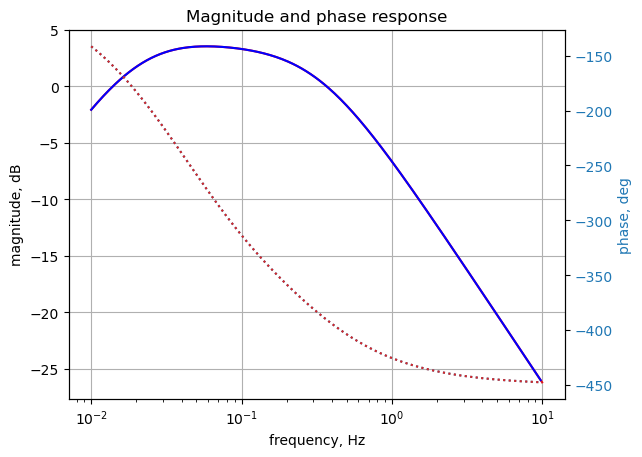

In [33]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-r')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

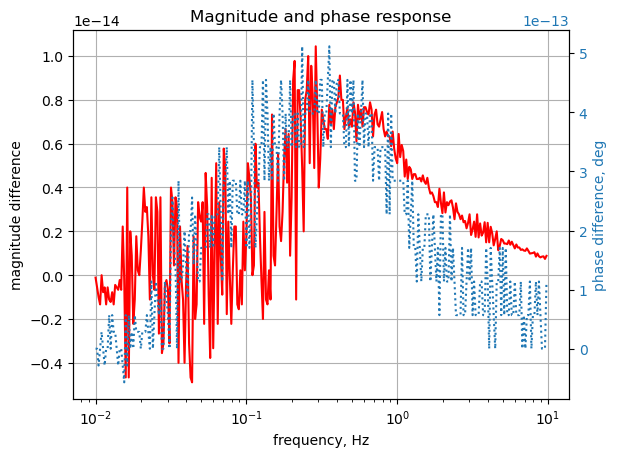

In [34]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude difference')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], np.abs(voltage[0:-1])-10**(mag/20),'-r')    # Bode magnitude plot
#plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.unwrap(2*np.angle(voltage[0:-1])/2) *180/np.pi - phase,':',color=color)  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase difference, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

The SymPy and LTSpice results overlay each other. The scale for the magnitude is $10^{-14}$ and $10^{-13}$ for the phase indicating the numerical difference is very small.  